# Modeling NHL Expected Goals

In [1]:
# Standard Packages
import pandas as pd
import numpy as np
import warnings
import re

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Modeling Packages
## Modeling Prep
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, \
GridSearchCV, RandomizedSearchCV

## SKLearn Data Prep Modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, \
PolynomialFeatures, PowerTransformer, Normalizer, MaxAbsScaler

from sklearn.impute import SimpleImputer

## SKLearn Classification Models
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor, AdaBoostClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


## SKLearn Pipeline Setup
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## SKLearn Model Optimization
from sklearn.feature_selection import RFE, f_regression

## Boosting
from xgboost import XGBRegressor
from xgboost import XGBClassifier

## SKLearn Metrics
### Classification Scoring/Evaluation
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, \
ConfusionMatrixDisplay, log_loss, confusion_matrix, RocCurveDisplay, make_scorer, roc_auc_score

In [3]:
# Notebook Config
## Suppress Python Warnings (Future, Deprecation)
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Suppress Pandas Warnings (SettingWithCopy)
pd.options.mode.chained_assignment = None

## Pandas Display Config
pd.options.display.max_columns = None
pd.options.display.width = None

## Display SKLearn estimators as diagrams
from sklearn import set_config
set_config(display= 'diagram')

## EDA

In [4]:
# Use 2021-22 data - most recent full season
s21_shots_df = pd.read_csv('project-data/shots_2021.csv')
s21_shots_df

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamCode,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff,distanceFromLastEvent,event,game_id,goal,goalieIdForShot,goalieNameForShot,homeEmptyNet,homePenalty1Length,homePenalty1TimeLeft,homeSkatersOnIce,homeTeamCode,homeTeamGoals,homeTeamWon,id,isHomeTeam,isPlayoffGame,lastEventCategory,lastEventShotAngle,lastEventShotDistance,lastEventTeam,lastEventxCord,lastEventxCord_adjusted,lastEventyCord,lastEventyCord_adjusted,location,offWing,period,playerNumThatDidEvent,playerNumThatDidLastEvent,playerPositionThatDidEvent,season,shooterLeftRight,shooterName,shooterPlayerId,shooterTimeOnIce,shooterTimeOnIceSinceFaceoff,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff,shotAngle,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotAngleReboundRoyalRoad,shotDistance,shotGeneratedRebound,shotGoalieFroze,shotOnEmptyNet,shotPlayContinuedInZone,shotPlayContinuedOutsideZone,shotPlayStopped,shotRebound,shotRush,shotType,shotWasOnGoal,speedFromLastEvent,team,teamCode,time,timeDifferenceSinceChange,timeSinceFaceoff,timeSinceLastEvent,timeUntilNextEvent,xCord,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
0,0,42.520583,61.0,61.0,-32.0,32.0,-8.400000,0,0,0,5,PIT,0,33.4,37.0,25.0,31.000000,25.000000,25.0,2,3,37,37,25,31,25,25,31,37,25,31,25,25,13.038405,SHOT,20001,0,8477465,Tristan Jarry,0,0,0,5,TBL,0,0,10,1.0,0,HIT,0.0,0.0,HOME,50,50,-39,-39,AWAYZONE,0,1,91,0,C,2021,R,Steven Stamkos,8474564.0,34,25,22.000000,4.0,4.0,34.000000,25.0,16.600000,2,3,34,4,4,34,25,25,4,4,4,34,25,4,-48.814075,48.814075,0.000000,0.000000,0,42.520583,0,1,0,0,0,0,0,0,WRIST,1.0,1.303840,HOME,TBL,63,-21,25,10,0,61,61,0.202514,0.009192,0.445979,0.289830,0.023891,0.028594,0.718082,-32,-32
1,1,30.610456,-65.0,65.0,19.0,19.0,21.400000,0,0,0,5,PIT,0,3.2,8.0,8.0,0.000000,0.000000,3.2,2,3,8,8,8,0,0,8,0,8,8,0,0,0,130.080744,SHOT,20001,0,8476883,Andrei Vasilevskiy,0,0,0,5,TBL,0,0,15,0.0,0,BLOCK,0.0,0.0,HOME,60,-60,-17,17,HOMEZONE,1,1,23,0,L,2021,L,Brock McGinn,8476934.0,41,41,24.600000,0.0,0.0,41.000000,41.0,24.600000,2,3,41,0,0,41,41,41,0,0,0,41,41,0,-38.367485,38.367485,38.367485,2.019341,0,30.610456,0,0,0,0,1,0,0,0,WRIST,1.0,6.846355,AWAY,PIT,104,0,41,19,13,-65,65,0.285948,0.031353,0.303080,0.325607,0.026384,0.027629,0.793188,19,-19
2

The dataset has 121,471 rows of shot instances and 124 columns

In [5]:
# Check the numeric column stats
s21_shots_df.describe()

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff,distanceFromLastEvent,game_id,goal,goalieIdForShot,homeEmptyNet,homePenalty1Length,homePenalty1TimeLeft,homeSkatersOnIce,homeTeamGoals,homeTeamWon,id,isHomeTeam,isPlayoffGame,lastEventShotAngle,lastEventShotDistance,lastEventxCord,lastEventxCord_adjusted,lastEventyCord,lastEventyCord_adjusted,offWing,period,playerNumThatDidEvent,playerNumThatDidLastEvent,season,shooterPlayerId,shooterTimeOnIce,shooterTimeOnIceSinceFaceoff,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff,shotAngle,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotAngleReboundRoyalRoad,shotDistance,shotGeneratedRebound,shotGoalieFroze,shotOnEmptyNet,shotPlayContinuedInZone,shotPlayContinuedOutsideZone,shotPlayStopped,shotRebound,shotRush,shotWasOnGoal,speedFromLastEvent,time,timeDifferenceSinceChange,timeSinceFaceoff,timeSinceLastEvent,timeUntilNextEvent,xCord,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
count,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.00000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,1.214710e+05,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.0,1.214680e+05,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.00000

Lots of numeric features of differing units/magnitude - data will require scaling

In [109]:
# Check data types and non-null counts
s21_shots_df.info(verbose=True, show_counts=True) # data is rather robust and clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121471 entries, 0 to 121470
Data columns (total 124 columns):
 #    Column                                                 Non-Null Count   Dtype  
---   ------                                                 --------------   -----  
 0    shotID                                                 121471 non-null  int64  
 1    arenaAdjustedShotDistance                              121471 non-null  float64
 2    arenaAdjustedXCord                                     121471 non-null  float64
 3    arenaAdjustedXCordABS                                  121471 non-null  float64
 4    arenaAdjustedYCord                                     121471 non-null  float64
 5    arenaAdjustedYCordAbs                                  121471 non-null  float64
 6    averageRestDifference                                  121471 non-null  float64
 7    awayEmptyNet                                           121471 non-null  int64  
 8    awayPenalty1Length    

In [6]:
# Check event types to make sure all rows are shots. Valid event values for shots are SHOT, MISS, GOAL
s21_shots_df['event'].value_counts() # all events are shots

SHOT    80180
MISS    32594
GOAL     8697
Name: event, dtype: int64

In [7]:
# check if postseason included
s21_shots_df['isPlayoffGame'].value_counts() # playoff games are included in the dataset

0    113158
1      8313
Name: isPlayoffGame, dtype: int64

In [8]:
# Check period column in case shootout attempts are included
s21_shots_df['period'].value_counts()

2    41584
1    39317
3    38793
4     1716
5       47
6       14
Name: period, dtype: int64

In [9]:
# Check how many extra periods are attributable to the post season
len(s21_shots_df.loc[(s21_shots_df['period'] >= 5) & (s21_shots_df['isPlayoffGame'] == 1)])

61

All instances of a 5th and 6th period are attributable to the post season, so shootouts have already been scrubbed

In [10]:
# Summarize missing data
pd.set_option('display.max_rows', 125)
s21_shots_df.isna().sum()

shotID                                                     0
arenaAdjustedShotDistance                                  0
arenaAdjustedXCord                                         0
arenaAdjustedXCordABS                                      0
arenaAdjustedYCord                                         0
arenaAdjustedYCordAbs                                      0
averageRestDifference                                      0
awayEmptyNet                                               0
awayPenalty1Length                                         0
awayPenalty1TimeLeft                                       0
awaySkatersOnIce                                           0
awayTeamCode                                               0
awayTeamGoals                                              0
defendingTeamAverageTimeOnIce                              0
defendingTeamAverageTimeOnIceOfDefencemen                  0
defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff      0
defendingTeamAverageTime

Features with missing values and counts
- goalieNameForShot                                        800
  - these probably are not missing, but indicative of empty net situations
- playerPositionThatDidEvent                                 4
- shooterLeftRight                                           3
- shooterName                                                3
- shooterPlayerId                                            3
- shotType                                                   5

Inspect shotType as other columns will be dropped

In [11]:
# Check shotType values
print(s21_shots_df['shotType'].value_counts())
print(s21_shots_df['shotType'].isna().sum())

WRIST    68003
SLAP     16413
SNAP     15529
BACK      8985
TIP       8404
DEFL      3129
WRAP      1003
Name: shotType, dtype: int64
5


In [13]:
# Drop the 5 rows missing shot type data
s21_shots_df = s21_shots_df.dropna(subset=['shotType'])
s21_shots_df

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamCode,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff,distanceFromLastEvent,event,game_id,goal,goalieIdForShot,goalieNameForShot,homeEmptyNet,homePenalty1Length,homePenalty1TimeLeft,homeSkatersOnIce,homeTeamCode,homeTeamGoals,homeTeamWon,id,isHomeTeam,isPlayoffGame,lastEventCategory,lastEventShotAngle,lastEventShotDistance,lastEventTeam,lastEventxCord,lastEventxCord_adjusted,lastEventyCord,lastEventyCord_adjusted,location,offWing,period,playerNumThatDidEvent,playerNumThatDidLastEvent,playerPositionThatDidEvent,season,shooterLeftRight,shooterName,shooterPlayerId,shooterTimeOnIce,shooterTimeOnIceSinceFaceoff,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff,shotAngle,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotAngleReboundRoyalRoad,shotDistance,shotGeneratedRebound,shotGoalieFroze,shotOnEmptyNet,shotPlayContinuedInZone,shotPlayContinuedOutsideZone,shotPlayStopped,shotRebound,shotRush,shotType,shotWasOnGoal,speedFromLastEvent,team,teamCode,time,timeDifferenceSinceChange,timeSinceFaceoff,timeSinceLastEvent,timeUntilNextEvent,xCord,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
0,0,42.520583,61.0,61.0,-32.0,32.0,-8.400000,0,0,0,5,PIT,0,33.4,37.0,25.0,31.000000,25.000000,25.0,2,3,37,37,25,31,25,25,31,37,25,31,25,25,13.038405,SHOT,20001,0,8477465,Tristan Jarry,0,0,0,5,TBL,0,0,10,1.0,0,HIT,0.0,0.0,HOME,50,50,-39,-39,AWAYZONE,0,1,91,0,C,2021,R,Steven Stamkos,8474564.0,34,25,22.000000,4.0,4.0,34.000000,25.0,16.600000,2,3,34,4,4,34,25,25,4,4,4,34,25,4,-48.814075,48.814075,0.000000,0.000000,0,42.520583,0,1,0,0,0,0,0,0,WRIST,1.0,1.303840,HOME,TBL,63,-21,25,10,0,61,61,0.202514,0.009192,0.445979,0.289830,0.023891,0.028594,0.718082,-32,-32
1,1,30.610456,-65.0,65.0,19.0,19.0,21.400000,0,0,0,5,PIT,0,3.2,8.0,8.0,0.000000,0.000000,3.2,2,3,8,8,8,0,0,8,0,8,8,0,0,0,130.080744,SHOT,20001,0,8476883,Andrei Vasilevskiy,0,0,0,5,TBL,0,0,15,0.0,0,BLOCK,0.0,0.0,HOME,60,-60,-17,17,HOMEZONE,1,1,23,0,L,2021,L,Brock McGinn,8476934.0,41,41,24.600000,0.0,0.0,41.000000,41.0,24.600000,2,3,41,0,0,41,41,41,0,0,0,41,41,0,-38.367485,38.367485,38.367485,2.019341,0,30.610456,0,0,0,0,1,0,0,0,WRIST,1.0,6.846355,AWAY,PIT,104,0,41,19,13,-65,65,0.285948,0.031353,0.303080,0.325607,0.026384,0.027629,0.793188,19,-19
2

In [16]:
# Check values of the target variable goal
s21_shots_df['goal'].value_counts() # binary with 1 representing a goal scored

0    112773
1      8693
Name: goal, dtype: int64

Our outcomes are very imbalanced. This will have to be addressed with oversampling or subsetting of data. 

## Visualize Shot Types & Goals

In [27]:
# Get normalized target variable ('goal') distribution
s21_shots_df['goal'].value_counts(normalize=True) # very imbalanced

0    0.928433
1    0.071567
Name: goal, dtype: float64

A model-less prediction (guess) will correctly predict a shot resulting in a goal scored only ~7.16% of the time

In [40]:
# Create goals DF
goals_df = s21_shots_df['goal'].value_counts().rename_axis('Shot Event').reset_index(name='Shot Event Count')
goals_df['Shot Event Count % of Unblocked Shot Attempts'] = goals_df['Shot Event Count'] / goals_df['Shot Event Count'].sum()
goals_df['Shot Event'][0] = 'Saved or Missed'
goals_df['Shot Event'][1] = 'Goal Scored'
goals_df

,Shot Event,Shot Event Count,Shot Event Count % of Unblocked Shot Attempts
0,Saved or Missed,112773,0.928433
1,Goal Scored,8693,0.071567


goals_df['Shot Event Count'].astype(str)

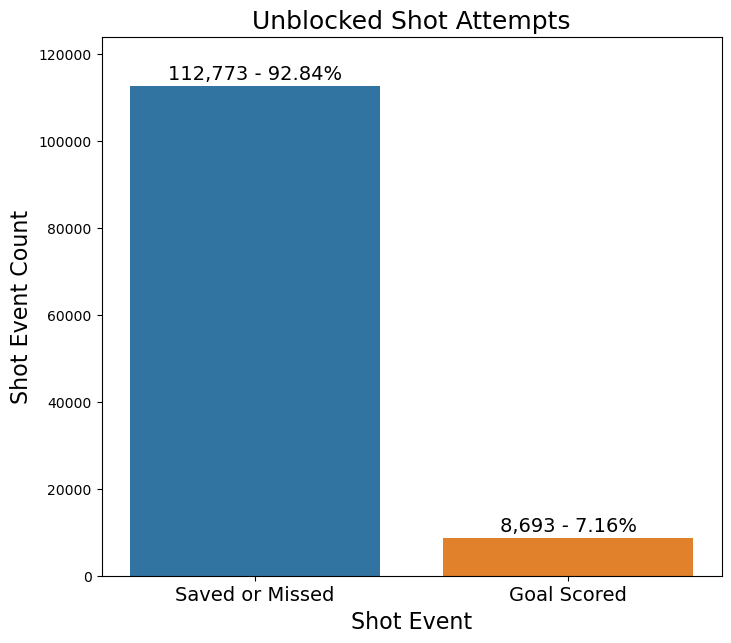

In [75]:
event_labels = goals_df["Shot Event Count"].map('{:,d}'.format) + ' - ' + np.round((goals_df['Shot Event Count % of Unblocked Shot Attempts'] * 100),2).astype(str) + '%'

fig, ax = plt.subplots(figsize=(8, 7))
ax = sns.barplot(x='Shot Event', y='Shot Event Count', data=goals_df)
ax.bar_label(ax.containers[0], labels=event_labels, padding=2, size=14)
ax.margins(y=0.1)
ax.margins(x=0.05)
plt.title("Unblocked Shot Attempts", size = 18)
plt.xlabel("Shot Event", size = 16)
plt.xticks(rotation=0, size=14)
plt.ylabel("Shot Event Count", size = 16)
plt.show()

In [78]:
# Random choice accuracy score
baseline_pred = np.ones(s21_shots_df.shape[0])
accuracy_score(s21_shots_df['goal'],baseline_pred)

0.07156735218085719

In [79]:
# Random choice log loss as that is the industry standard metric for xG models
baseline_probs = np.repeat(s21_shots_df['goal'].value_counts(normalize=True)[1], s21_shots_df.shape[0])
log_loss(s21_shots_df['goal'], baseline_probs)

0.2576744610404474

In [80]:
# Create shots taken by shotType DF
shot_types_df = s21_shots_df['shotType'].value_counts().rename_axis('Shot Type').reset_index(name='Shots Taken')
shot_types_df['Shot Type % of Shots Taken'] = shot_types_df['Shots Taken'] / shot_types_df['Shots Taken'].sum()
shot_types_df

,Shot Type,Shots Taken,Shot Type % of Shots Taken
0,WRIST,68003,0.559852
1,SLAP,16413,0.135124
2,SNAP,15529,0.127846
3,BACK,8985,0.073971
4,TIP,8404,0.069188
5,DEFL,3129,0.025760
6,WRAP,1003,0.008257


In [81]:
# Create df for goal shot types
goals_scored = s21_shots_df['goal'] == 1
goals_by_type = goals_scored.groupby(s21_shots_df['shotType']).sum().rename_axis('Shot Type').reset_index(name='Goals Scored')
goals_by_type['Shot Type % of Goals Scored'] = goals_by_type['Goals Scored'] / goals_by_type['Goals Scored'].sum()
goals_by_type

,Shot Type,Goals Scored,Shot Type % of Goals Scored
0,BACK,834,0.095939
1,DEFL,280,0.032210
2,SLAP,829,0.095364
3,SNAP,1356,0.155988
4,TIP,804,0.092488
5,WRAP,43,0.004947
6,WRIST,4547,0.523065


In [82]:
# Merge the goals scored df into shots taken
shot_types_df = shot_types_df.merge(goals_by_type, on='Shot Type', how='inner')
shot_types_df

,Shot Type,Shots Taken,Shot Type % of Shots Taken,Goals Scored,Shot Type % of Goals Scored
0,WRIST,68003,0.559852,4547,0.523065
1,SLAP,16413,0.135124,829,0.095364
2,SNAP,15529,0.127846,1356,0.155988
3,BACK,8985,0.073971,834,0.095939
4,TIP,8404,0.069188,804,0.092488
5,DEFL,3129,0.025760,280,0.032210
6,WRAP,1003,0.008257,43,0.004947


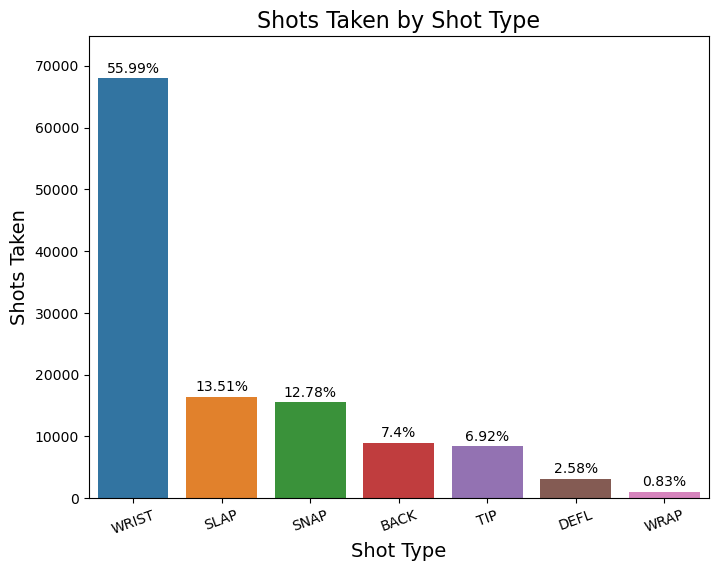

In [83]:
shots_labels = np.round((shot_types_df['Shot Type % of Shots Taken'] * 100),2).astype(str) + '%'

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(x='Shot Type', y='Shots Taken', data=shot_types_df)
ax.bar_label(ax.containers[0], labels=shots_labels, padding=2)
ax.margins(y=0.1)
# ax.margins(x=0.05)
plt.title("Shots Taken by Shot Type", size = 16)
plt.xlabel("Shot Type", size = 14)
plt.xticks(rotation=20)
plt.ylabel("Shots Taken", size = 14)
plt.show()

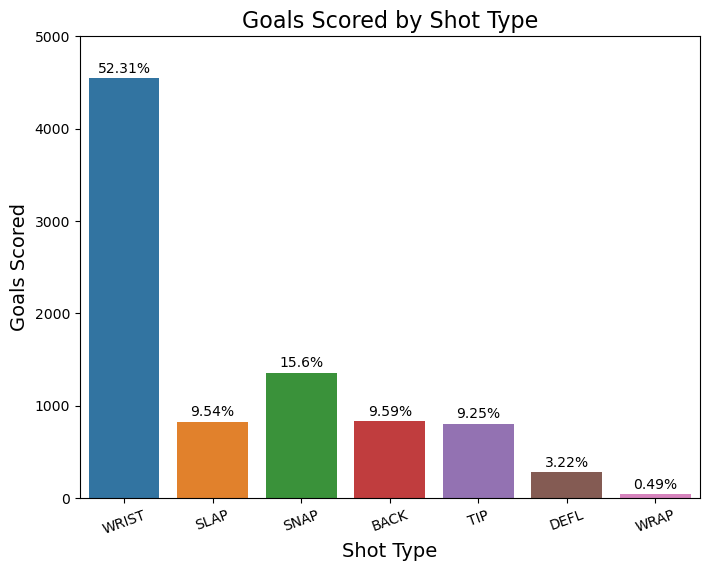

In [84]:
goals_labels = np.round((shot_types_df['Shot Type % of Goals Scored'] * 100),2).astype(str) + '%'

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(x='Shot Type', y='Goals Scored', data=shot_types_df)
ax.bar_label(ax.containers[0], labels=goals_labels, padding=2)
ax.margins(y=0.1)
# ax.margins(x=0.05)
plt.title("Goals Scored by Shot Type", size = 16)
plt.xlabel("Shot Type", size = 14)
plt.xticks(rotation=20)
plt.ylabel("Goals Scored", size = 14)
plt.show()

## Feature Engineering

In [85]:
# Features from dataset to be included model
cols_to_keep = (pd.read_csv('project-data/feature-list.csv', header=None))
cols_to_keep = cols_to_keep[0].to_list()
cols_to_keep

['homeSkatersOnIce',
 'awaySkatersOnIce',
 'isHomeTeam',
 'shotType',
 'shotRush',
 'arenaAdjustedShotDistance',
 'arenaAdjustedXCordABS',
 'arenaAdjustedYCordAbs',
 'shotAngleAdjusted',
 'shotAnglePlusRebound',
 'shotAnglePlusReboundSpeed',
 'shotOnEmptyNet',
 'timeSinceLastEvent',
 'distanceFromLastEvent',
 'lastEventxCord_adjusted',
 'lastEventyCord_adjusted',
 'speedFromLastEvent',
 'offWing',
 'goal']

In [86]:
# New df with unnecessary columns dropped and index reset
shots_df = s21_shots_df[cols_to_keep].reset_index(drop=True)
shots_df

,homeSkatersOnIce,awaySkatersOnIce,isHomeTeam,shotType,shotRush,arenaAdjustedShotDistance,arenaAdjustedXCordABS,arenaAdjustedYCordAbs,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotOnEmptyNet,timeSinceLastEvent,distanceFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,speedFromLastEvent,offWing,goal
0,5,5,1.0,WRIST,0,42.520583,61.0,32.0,48.814075,0.000000,0.000000,0,10,13.038405,50,-39,1.303840,0,0
1,5,5,0.0,WRIST,0,30.610456,65.0,19.0,38.367485,38.367485,2.019341,0,19,130.080744,-60,17,6.846355,1,0
2,5,5,1.0,WRIST,0,85.381497,8.0,27.0,18.434949,0.000000,0.000000,0,4,60.415230,67,40,15.103807,1,0
3,5,5,0.0,WRIST,0,29.274562,60.0,4.0,7.853313,0.000000,0.000000,0,2,19.723083,70,-13,9.861541,0,0
4,5,5,1.0,WRIST,0,26.305893,63.0,4.0,8.746162,0.000000,0.000000,0,19,134.536240,-69,-22,7.080855,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121461,5,5,1.0,SNAP,0,30.463092,61.0,12.0,23.198591,0.000000,0.000000,0,11,12.806248,69,-22,1.164204,1,0
121462,5,5,1.0,TIP,0,16.278821,73.0,3.0,10.619655,0.000000,0.000000,0,12,58.600341,20,22,4.883362,1,0
121463,5,5,0.0,SNAP,0,41.194660,48.0,4.0,5.572198,0.000000,0.000000,0,16,26.076810,74,-2,1.629801,1,0
121464,6,5,1.0,TIP,0,17.000000,72.0,0.0,0.000000,0.000000,0.000000,0,5,5.385165,74,-5,1.077033,0,0


### Add Game Strength State Variable

Takes the number of players on the ice for each team (homeSkatersOnIce & awaySkatersOnIce) to derive even strength, powerplay, and shorthanded game states

In [87]:
# add column for game_strength_state
shots_df['game_strength_state'] = ''

In [88]:
# Add even strength game state values
shots_df.loc[(shots_df['homeSkatersOnIce'] == 3) & (shots_df['awaySkatersOnIce'] == 3), 
             'game_strength_state'] = 'EV3'
shots_df.loc[(shots_df['homeSkatersOnIce'] == 4) & (shots_df['awaySkatersOnIce'] == 4), 
             'game_strength_state'] = 'EV4'
shots_df.loc[(shots_df['homeSkatersOnIce'] == 5) & (shots_df['awaySkatersOnIce'] == 5), 
             'game_strength_state'] = 'EV5'
shots_df

,homeSkatersOnIce,awaySkatersOnIce,isHomeTeam,shotType,shotRush,arenaAdjustedShotDistance,arenaAdjustedXCordABS,arenaAdjustedYCordAbs,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotOnEmptyNet,timeSinceLastEvent,distanceFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,speedFromLastEvent,offWing,goal,game_strength_state
0,5,5,1.0,WRIST,0,42.520583,61.0,32.0,48.814075,0.000000,0.000000,0,10,13.038405,50,-39,1.303840,0,0,EV5
1,5,5,0.0,WRIST,0,30.610456,65.0,19.0,38.367485,38.367485,2.019341,0,19,130.080744,-60,17,6.846355,1,0,EV5
2,5,5,1.0,WRIST,0,85.381497,8.0,27.0,18.434949,0.000000,0.000000,0,4,60.415230,67,40,15.103807,1,0,EV5
3,5,5,0.0,WRIST,0,29.274562,60.0,4.0,7.853313,0.000000,0.000000,0,2,19.723083,70,-13,9.861541,0,0,EV5
4,5,5,1.0,WRIST,0,26.305893,63.0,4.0,8.746162,0.000000,0.000000,0,19,134.536240,-69,-22,7.080855,0,0,EV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121461,5,5,1.0,SNAP,0,30.463092,61.0,12.0,23.198591,0.000000,0.000000,0,11,12.806248,69,-22,1.164204,1,0,EV5
121462,5,5,1.0,TIP,0,16.278821,73.0,3.0,10.619655,0.000000,0.000000,0,12,58.600341,20,22,4.883362,1,0,EV5
121463,5,5,0.0,SNAP,0,41.194660,48.0,4.0,5.572198,0.000000,0.000000,0,16,26.076810,74,-2,1.629801,1,0,EV5
121464,6,5,1.0,TIP,0,17.000000,72.0,0.0,0.000000,0.000000,0.000000,0,5,5.385165,74,-5,1.077033,0,0,


In [89]:
# Add Home team game_strength_state
shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 5) & 
       (shots_df['awaySkatersOnIce'] == 4), 'game_strength_state'] = 'PP_5v4'

shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 5) & 
       (shots_df['awaySkatersOnIce'] == 3), 'game_strength_state'] = 'PP_5v3'

shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 4) & 
       (shots_df['awaySkatersOnIce'] == 3), 'game_strength_state'] = 'PP_4v3'

shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 6) & 
       (shots_df['awaySkatersOnIce'] == 5), 'game_strength_state'] = 'PP_6v5'

shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 6) & 
       (shots_df['awaySkatersOnIce'] == 4), 'game_strength_state'] = 'PP_6v4'

In [90]:
# Add Away team game_strength_state
shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 4) & 
       (shots_df['awaySkatersOnIce'] == 5), 'game_strength_state'] = 'PP_5v4'

shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 3) & 
       (shots_df['awaySkatersOnIce'] == 5), 'game_strength_state'] = 'PP_5v3'

shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 3) & 
       (shots_df['awaySkatersOnIce'] == 4), 'game_strength_state'] = 'PP_4v3'

shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 5) & 
       (shots_df['awaySkatersOnIce'] == 6), 'game_strength_state'] = 'PP_6v5'

shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 4) & 
       (shots_df['awaySkatersOnIce'] == 6), 'game_strength_state'] = 'PP_6v4'

In [91]:
# Add shorthandeed game_strength_state
# Binning all man down strength states into one shorthanded, 'SH', bucket
shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] < shots_df['awaySkatersOnIce']),
             'game_strength_state'] = 'SH'
shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['awaySkatersOnIce'] < shots_df['homeSkatersOnIce']),
             'game_strength_state'] = 'SH'

In [92]:
shots_df

,homeSkatersOnIce,awaySkatersOnIce,isHomeTeam,shotType,shotRush,arenaAdjustedShotDistance,arenaAdjustedXCordABS,arenaAdjustedYCordAbs,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotOnEmptyNet,timeSinceLastEvent,distanceFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,speedFromLastEvent,offWing,goal,game_strength_state
0,5,5,1.0,WRIST,0,42.520583,61.0,32.0,48.814075,0.000000,0.000000,0,10,13.038405,50,-39,1.303840,0,0,EV5
1,5,5,0.0,WRIST,0,30.610456,65.0,19.0,38.367485,38.367485,2.019341,0,19,130.080744,-60,17,6.846355,1,0,EV5
2,5,5,1.0,WRIST,0,85.381497,8.0,27.0,18.434949,0.000000,0.000000,0,4,60.415230,67,40,15.103807,1,0,EV5
3,5,5,0.0,WRIST,0,29.274562,60.0,4.0,7.853313,0.000000,0.000000,0,2,19.723083,70,-13,9.861541,0,0,EV5
4,5,5,1.0,WRIST,0,26.305893,63.0,4.0,8.746162,0.000000,0.000000,0,19,134.536240,-69,-22,7.080855,0,0,EV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121461,5,5,1.0,SNAP,0,30.463092,61.0,12.0,23.198591,0.000000,0.000000,0,11,12.806248,69,-22,1.164204,1,0,EV5
121462,5,5,1.0,TIP,0,16.278821,73.0,3.0,10.619655,0.000000,0.000000,0,12,58.600341,20,22,4.883362,1,0,EV5
121463,5,5,0.0,SNAP,0,41.194660,48.0,4.0,5.572198,0.000000,0.000000,0,16,26.076810,74,-2,1.629801,1,0,EV5
121464,6,5,1.0,TIP,0,17.000000,72.0,0.0,0.000000,0.000000,0.000000,0,5,5.385165,74,-5,1.077033,0,0,PP_6v5


In [93]:
# Check game_strength_state value counts to ensure proper encoding
print(shots_df['game_strength_state'].value_counts())
# Also check normalized count formatted as a percentage
print(shots_df['game_strength_state'].value_counts(normalize=True).mul(100).round(1).astype(str) + '0%')

EV5       95454
PP_5v4    16058
SH         3900
PP_6v5     2137
EV4        1495
EV3        1322
PP_5v3      535
PP_6v4      294
PP_4v3      263
              8
Name: game_strength_state, dtype: int64
EV5       78.60%
PP_5v4    13.20%
SH         3.20%
PP_6v5     1.80%
EV4        1.20%
EV3        1.10%
PP_5v3     0.40%
PP_6v4     0.20%
PP_4v3     0.20%
           0.00%
Name: game_strength_state, dtype: object


8 situations are unencoded. These must be strength state situations such as 6 on 3, which are very rare. These unencoded situations are so infrequent, they make up less than .00% of the data

In [95]:
# Given the rarity of 6v3 states, best to drop those 8 rows
shots_df = shots_df.loc[shots_df['game_strength_state'] != '']

In [97]:
# Drop homeSkatersOnIce & awaySkatersOnIce now that we have derived strength states
shots_df = shots_df.drop(['homeSkatersOnIce', 'awaySkatersOnIce'], axis=1)

KeyError: "['homeSkatersOnIce', 'awaySkatersOnIce'] not found in axis"

In [98]:
# check dtypes and non-null counts of our new df
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121458 entries, 0 to 121465
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   isHomeTeam                 121458 non-null  float64
 1   shotType                   121458 non-null  object 
 2   shotRush                   121458 non-null  int64  
 3   arenaAdjustedShotDistance  121458 non-null  float64
 4   arenaAdjustedXCordABS      121458 non-null  float64
 5   arenaAdjustedYCordAbs      121458 non-null  float64
 6   shotAngleAdjusted          121458 non-null  float64
 7   shotAnglePlusRebound       121458 non-null  float64
 8   shotAnglePlusReboundSpeed  121458 non-null  float64
 9   shotOnEmptyNet             121458 non-null  int64  
 10  timeSinceLastEvent         121458 non-null  int64  
 11  distanceFromLastEvent      121458 non-null  float64
 12  lastEventxCord_adjusted    121458 non-null  int64  
 13  lastEventyCord_adjusted    12

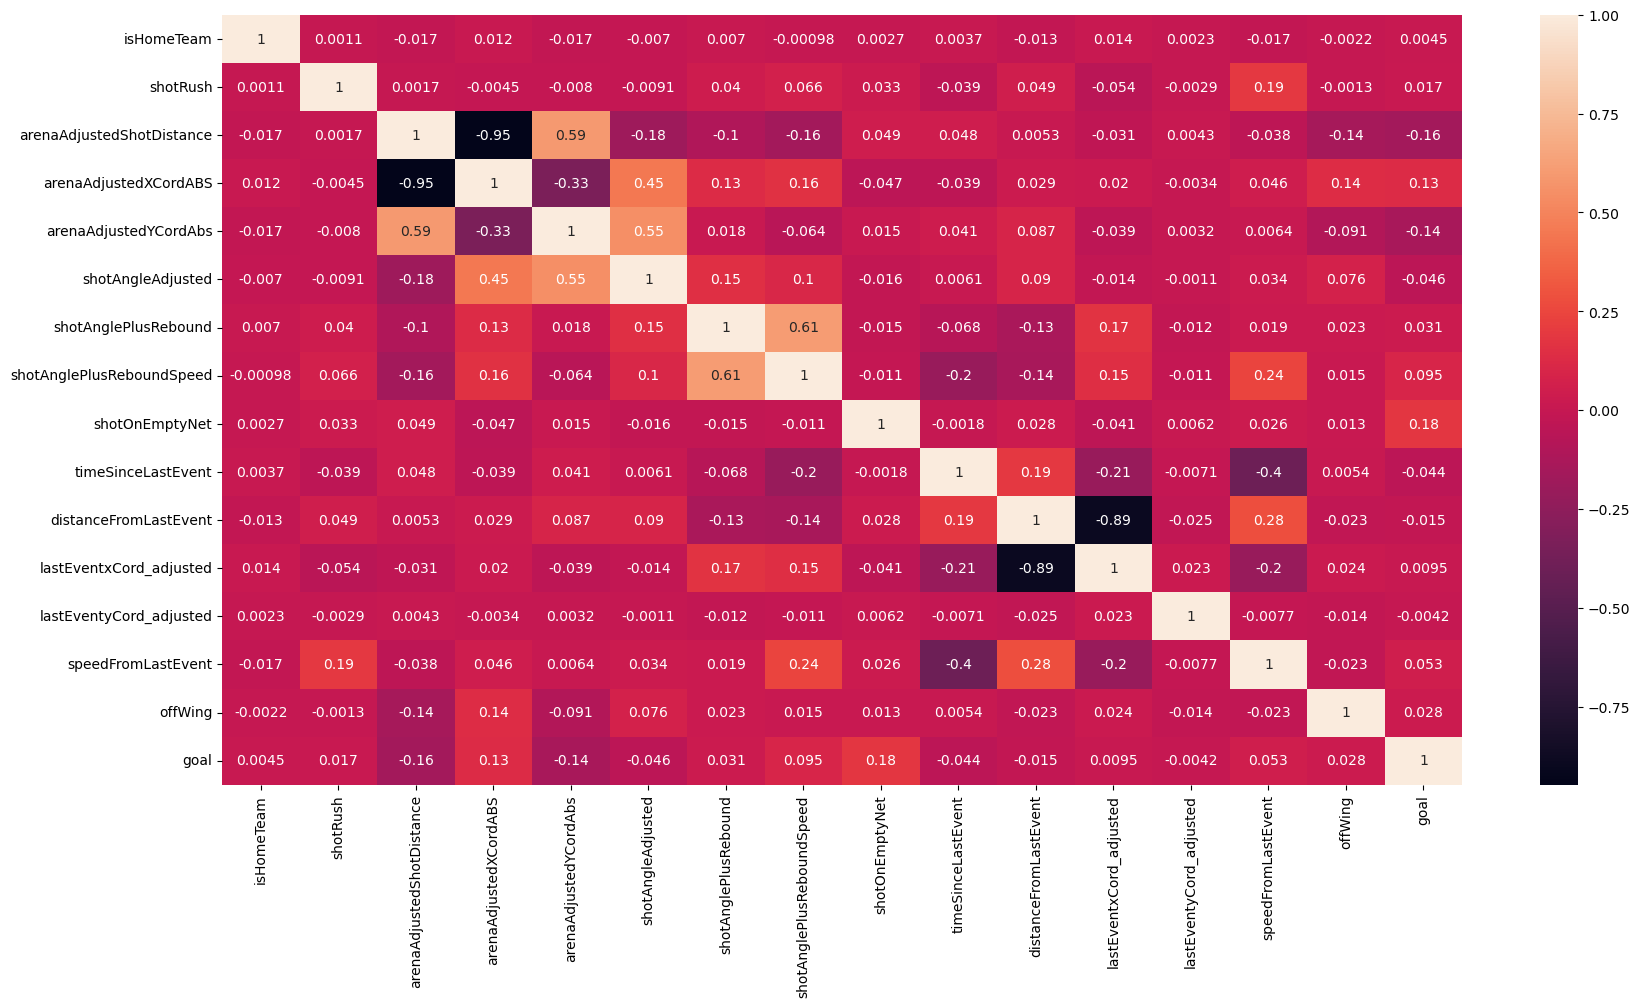

In [99]:
# Check correlation of selected features
plt.figure(figsize=(20,10))
cor = shots_df.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [100]:
# Table of heatmap values
shots_df.corr().sort_values('goal')

,isHomeTeam,shotRush,arenaAdjustedShotDistance,arenaAdjustedXCordABS,arenaAdjustedYCordAbs,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotOnEmptyNet,timeSinceLastEvent,distanceFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,speedFromLastEvent,offWing,goal
arenaAdjustedShotDistance,-0.016761,0.001695,1.000000,-0.947619,0.590378,-0.182928,-0.100762,-0.157389,0.048856,0.047815,0.005268,-0.030524,0.004298,-0.038165,-0.143048,-0.159274
arenaAdjustedYCordAbs,-0.017398,-0.007993,0.590378,-0.334509,1.000000,0.547959,0.018225,-0.064065,0.014748,0.040926,0.087198,-0.039023,0.003242,0.006368,-0.090961,-0.140692
shotAngleAdjusted,-0.007015,-0.009066,-0.182928,0.446281,0.547959,1.000000,0.151187,0.103049,-0.016299,0.006107,0.090004,-0.013818,-0.001130,0.033653,0.075778,-0.046107
timeSinceLastEvent,0.003695,-0.039049,0.047815,-0.038922,0.040926,0.006107,-0.068224,-0.202267,-0.001849,1.000000,0.190687,-0.206977,-0.007057,-0.402057,0.005430,-0.043644
distanceFromLastEvent,-0.013339,0.049403,0.005268,0.028941,0.087198,0.090004,-0.130546,-0.138897,0.027952,0.190687,1.000000,-0.891811,-0.024569,0.284685,-0.022594,-0.014520
lastEventyCord_adjusted,0.002280,-0.002862,0.004298,-0.003381,0.003242,-0.001130,-0.012404,-0.010687,0.006188,-0.007057,-0.024569,0.022782,1.000000,-0.007732,-0.014137,-0.004205
isHomeTeam,1.000000,0.001061,-0.016761,0.012293,-0.017398,-0.007015,0.006989,-0.000976,0.002700,0.003695,-0.013339,0.014344,0.002280,-0.016954,-0.002152,0.004467
lastEventxCord_adjusted,0.014344,-0.054039,-0.030524,0.020229,-0.039023,-0.013818,0.169308,0.147170,-0.040889,-0.206977,-0.891811,1.000000,0.022782,-0.203705,0.024387,0.009483
shotRush,0.001061,1.000000,0.001695,-0.004502,-0.007993,-0.009066,0.039548,0.065869,0.032686,-0.039049,0.049403,-0.054039,-0.002862,0.188586,-0.001291,0.016706
offWing,-0.002152,-0.001291,-0.143048,0.135396,-0.090961,0.075778,0.022918,0.015478,0.012671,0.005430,-0.022594,0.024387,-0.014137,-0.023189,1.000000,0.027549


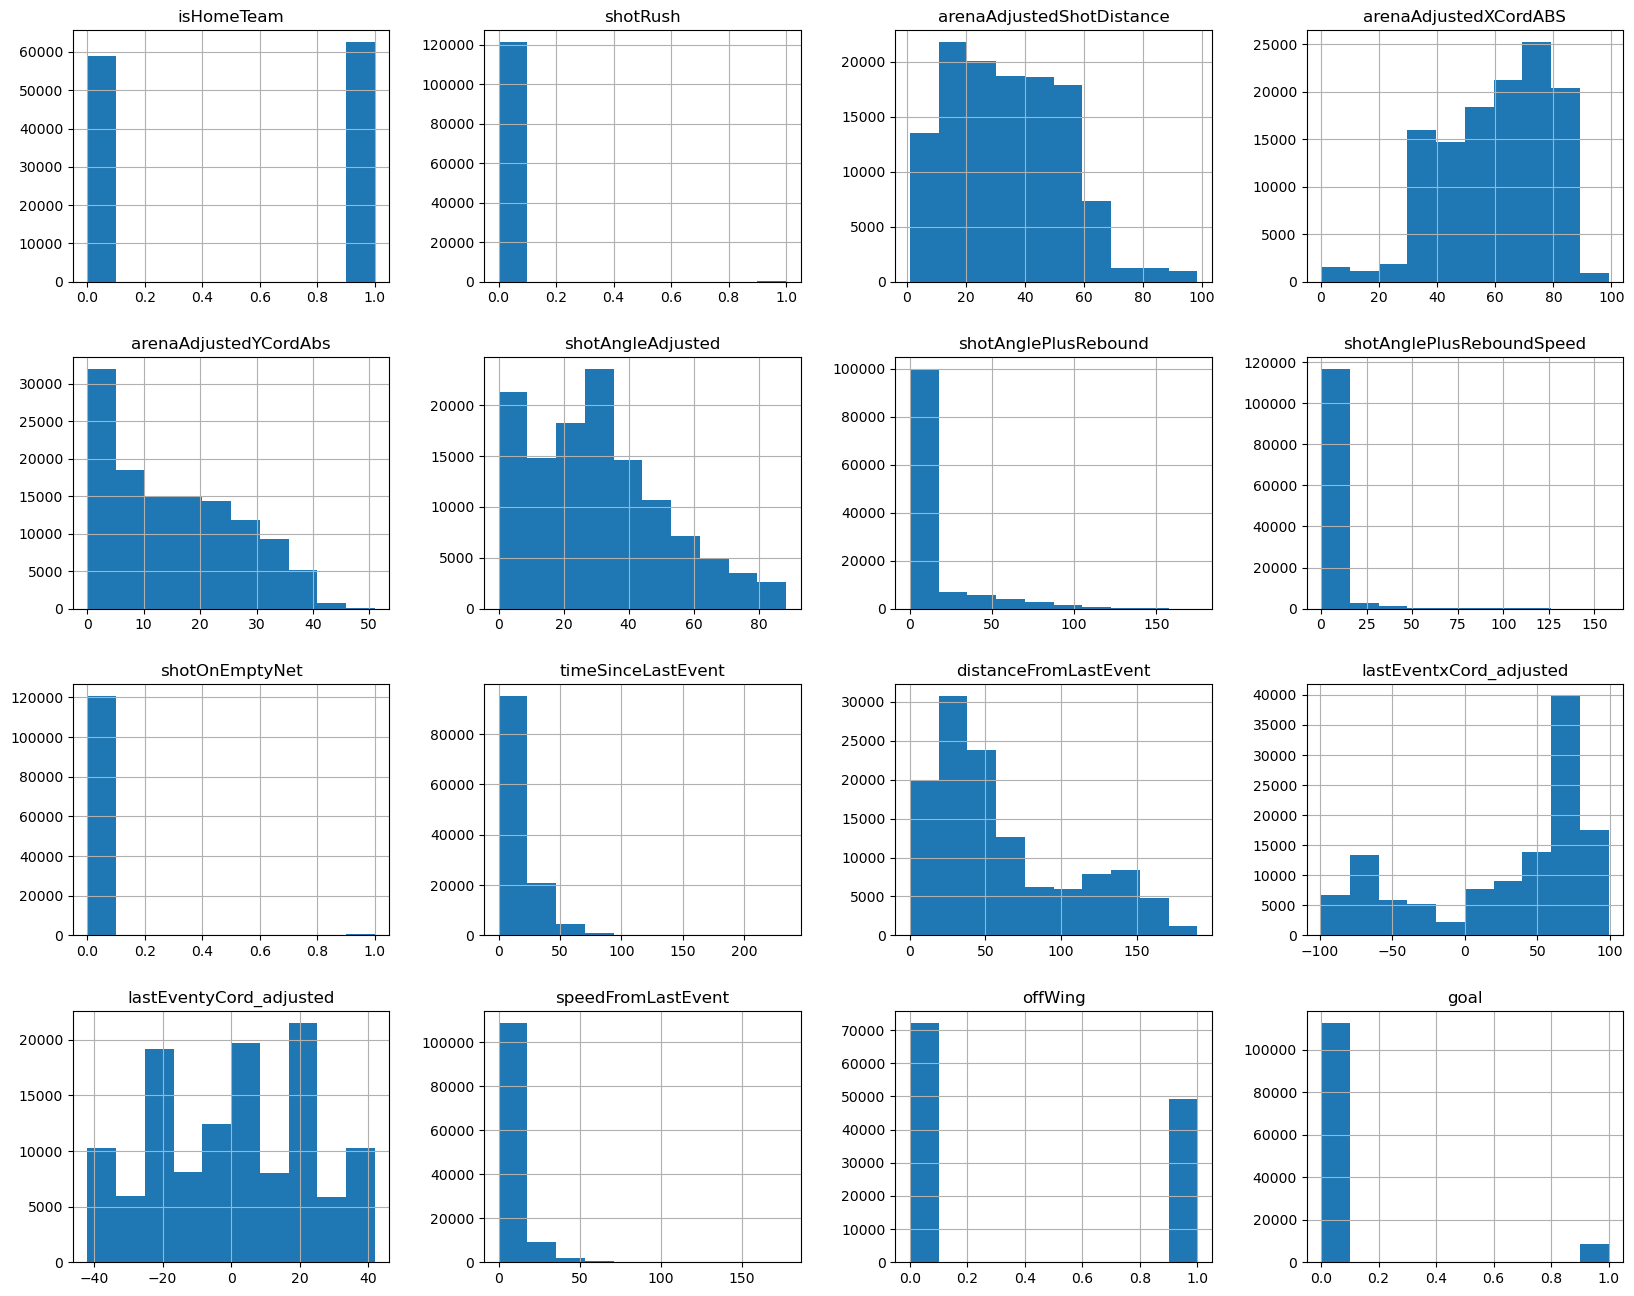

In [101]:
# Visualize distributions of numerical features
shots_df.hist(bins=10, figsize=(20, 16))
plt.show()

## Baseline 

## Modeling 

### Build Pipeline

In [102]:
# Separate target variable 'goal' from feature set
# and perform a stratified test_train_split due to high imbalance 
X = shots_df.drop(['goal'], axis = 1)
y = shots_df['goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state= 42)

In [108]:
# X_train.shape
y_train.value_counts()

0    84574
1     6519
Name: goal, dtype: int64

In [103]:
# Assign training sets of numeric and categorical columns to respective variables
num_features = X_train.select_dtypes(['int', 'float']).columns
cat_features = X_train.select_dtypes(['object']).columns

In [109]:
# Establish pipelines for each feature type
numeric_pipeline = Pipeline([('ss', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(handle_unknown = 'ignore')), 
    ('onehotnorm', MaxAbsScaler())])

# declare scoring metric list
scoring = ['neg_log_loss', 'accuracy']

In [110]:
# Instantiate the column transformer 
ct = ColumnTransformer(transformers=
    [("numpipe", numeric_pipeline, num_features),
     ("nominalpipe", nominal_pipeline, cat_features)])

In [111]:
ct 

ColumnTransformer(transformers=[('numpipe',
                                 Pipeline(steps=[('ss', StandardScaler())]),
                                 Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromLastEvent',
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')),
                                ('nominalpipe',
                                 Pipeline(steps=[('onehotenc',
                                                  OneHotEncoder(handle_unknown='ignore')),
                                                 ('onehotnorm',
                                                  MaxAbsScaler())]),
                                 Index(['shotType', 'game_strength_state'], dtype='object'))])

In [112]:
num_features

Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromLastEvent',
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')

In [122]:
# get feature names after encoding
feature_names = list(nominal_pipeline.named_steps['onehotenc'].fit(X_train[cat_features]).get_feature_names_out())

In [124]:
import re
# removes the OHE strings at front end of feature names
def clean_ohe_names(feature_list):
    extracted_names = []
    for feature in feature_list:
        match = re.search(r'_([^_]*)$', feature)
        if match:
            extracted_names.append(match.group(1))
    return extracted_names

In [125]:
cleaned_features = clean_ohe_names(feature_names)
num_features_names = list(num_features)
# put into a dataframe
feature_names_df = pd.DataFrame(cleaned_features)
# add the numerical cols at end of dataframe
feature_names_df = feature_names_df.append(num_features_names)
feature_names_df = feature_names_df.reset_index().drop(columns = 'index')

## Basic Logistic Regression Model

In [115]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('logreg', LogisticRegression(random_state = 42, max_iter=10000))]

base_log_reg_pipeline = Pipeline(steps)

base_log_reg_pipeline.fit(X_train, y_train)

# Predict using the pipeline 
base_log_y_pred = base_log_reg_pipeline.predict(X_test)

In [117]:
# Evaluate the accuracy of the predictions
accuracy = accuracy_score(y_test, base_log_y_pred)
print(f'Test accuracy: {accuracy:.3f}')

# Calculate the F1 score for the test set
f1 = f1_score(y_test, base_log_y_pred,average='macro')
print(f'Test F1 score: {f1:.3f}')

# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

Test accuracy: 0.929
Test F1 score: 0.517
Test AUC-ROC score: 0.756
Test log loss score: 0.228


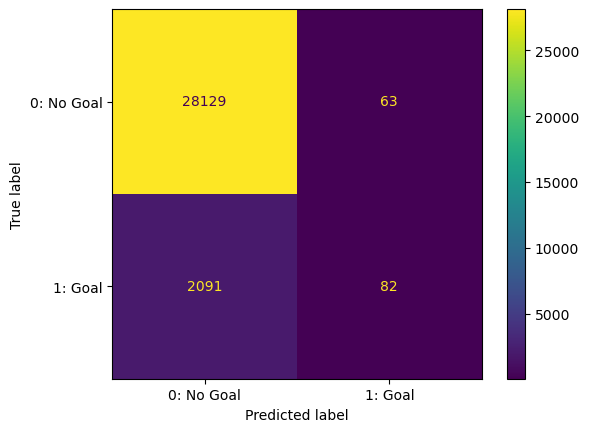

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     28192
           1       0.57      0.04      0.07      2173

    accuracy                           0.93     30365
   macro avg       0.75      0.52      0.52     30365
weighted avg       0.90      0.93      0.90     30365

Test log loss score: 0.228
Test AUC-ROC score: 0.756


In [119]:
# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, base_log_y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, base_log_y_pred)
print(f'Classification report:\n{report}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')# Calculate the AUC-ROC score for the test set
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

## Basic Random Forrest  Model

In [120]:
# build baseline trees pipeplin
steps = [('preprocess', ct), 
         ('rf', RandomForestClassifier(random_state = 42))]

rf_pipeline = Pipeline(steps)

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromLastEvent',
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['shotType', 'game_strength_state'], dtype='object'))])),
                ('rf', RandomForestClassifier(random_state=42))])

In [126]:
pd.DataFrame(zip(feature_names_df[0].values,
                 rf_pipeline[1].feature_importances_)).sort_values(by = 1,
                                                                    ascending = False).head()

,0,1
13,6v4,0.113028
10,4v3,0.107194
5,WRAP,0.090000
2,SLAP,0.088823
12,5v4,0.085278


In [154]:
# create df for viz
feat_importances = pd.DataFrame(columns=['Feature','Importance'])
feat_importances['Feature'] = feature_names_df[0].values
feat_importances['Importance'] = rf_pipeline[1].feature_importances_
feat_importances.sort_values('Importance',inplace=True, ascending=False)


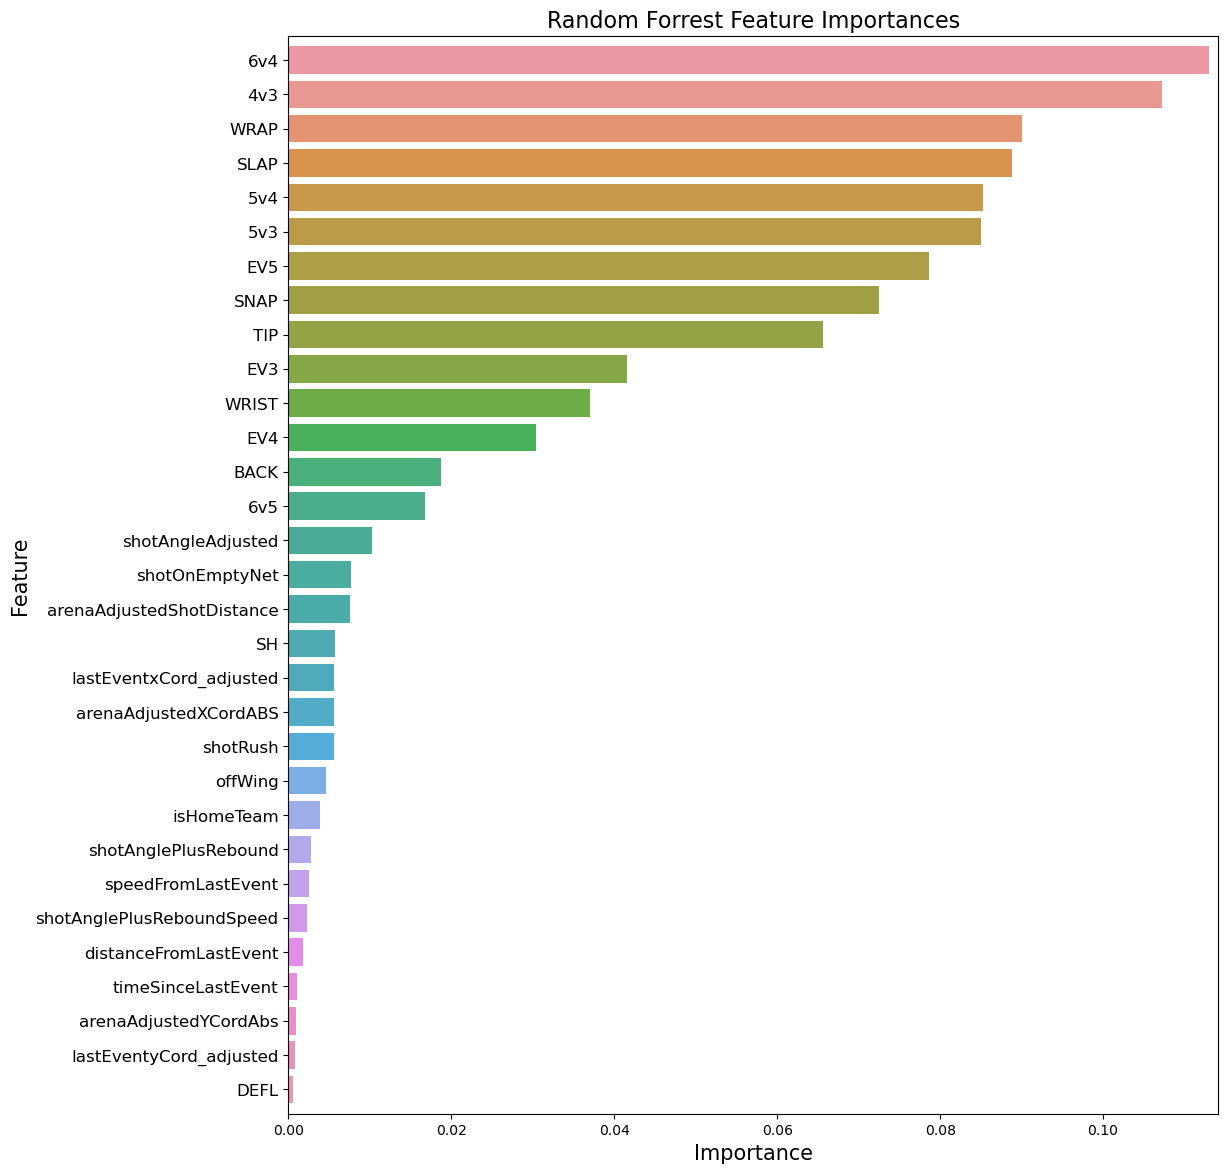

In [181]:
fig, ax = plt.subplots(figsize=(12, 14))
ax = sns.barplot(x='Importance', y='Feature', data=feat_importances)
# ax.bar_label(ax.containers[0], padding=2)
ax.margins(y=0.01)
ax.margins(x=0.01)
plt.title("Random Forrest Feature Importances", size = 16)
plt.xlabel("Importance", size = 15)
plt.xticks(rotation=0)
plt.ylabel("Feature", size = 15)
plt.yticks(rotation=0, size=12)
plt.show()

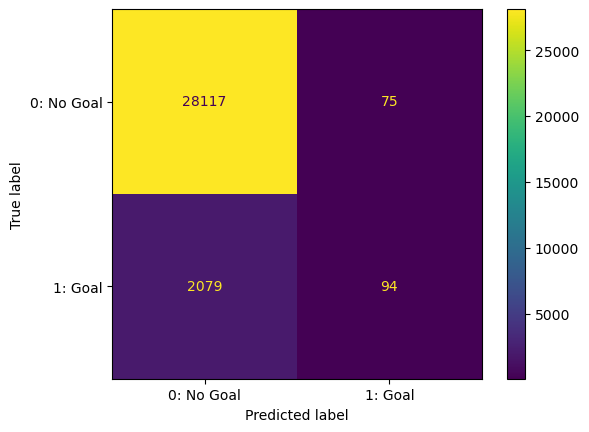

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     28192
           1       0.56      0.04      0.08      2173

    accuracy                           0.93     30365
   macro avg       0.74      0.52      0.52     30365
weighted avg       0.90      0.93      0.90     30365

Test AUC-ROC score: 0.737
Test log loss score: 0.287


In [179]:
# Predict using the pipeline 
y_pred_rf = rf_pipeline.predict(X_test)

# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, y_pred_rf)
print(f'Classification report:\n{report}')
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')
# Calculate the Log-Loss score for the test set
log_loss_score = log_loss(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

## Adding SMOTE to Handle Data Imbalance

In [184]:
# RandomForestClassifier with smote
steps = [('preprocess', ct),
    ('smote', SMOTE(sampling_strategy='minority')),
#          ('random', RandomOverSampler()),
         ('rf_clf', RandomForestClassifier())]

rf_clf_smote = Pipeline(steps)

rf_clf_smote.fit(X_train,y_train)
print('test: {}'.format(rf_clf_smote.score(X_test,y_test)))
print('train: {}'.format(rf_clf_smote.score(X_train,y_train)))

test: 0.9130577968055327
train: 0.9999780444161461


In [186]:
rf_clf_smote

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromLastEv...
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['shotType', 'game_strength_state'], dtype='object'))])),
                ('smote', SMOTE(sampling_strategy='minority')),
                ('rf_clf', RandomForestClassifier())])

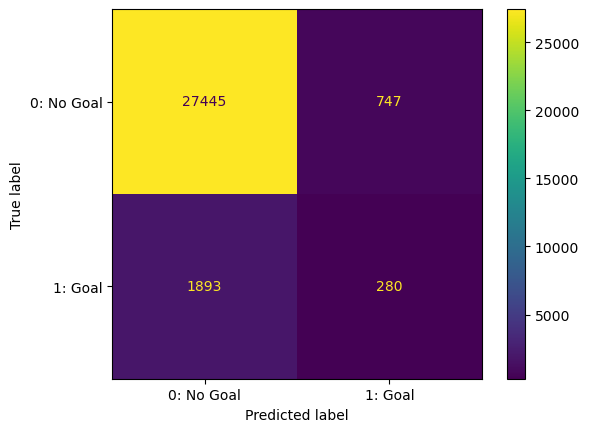

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     28192
           1       0.27      0.13      0.18      2173

    accuracy                           0.91     30365
   macro avg       0.60      0.55      0.56     30365
weighted avg       0.89      0.91      0.90     30365

Test AUC-ROC score: 0.728
Test log loss score: 0.301


In [185]:
# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
y_pred_clf_smote = rf_clf_smote.predict(X_test)
cm = confusion_matrix(y_test, y_pred_clf_smote)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, y_pred_clf_smote)
print(f'Classification report:\n{report}')
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, rf_clf_smote.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, rf_clf_smote.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

## Cross Validated Logistic Regression with SMOTE

In [194]:
# Logistic Regression CV
steps = [('preprocess', ct),
        ('smote', SMOTE(sampling_strategy='minority')),
         ('logisticregression', LogisticRegression(max_iter = 10000))]

log_cv_pipeline = Pipeline(steps=steps)

#paramters to test with the grid search
log_params = {'logisticregression__solver' : ['saga','lbfgs'],
                'logisticregression__penalty': [None, 'l2'],
                'logisticregression__C': [.05, 0.1, 1]}

log_cv = GridSearchCV(log_cv_pipeline, param_grid=log_params, cv=5, verbose=0, error_score='raise')

# log_cv = GridSearchCV(log_cv_pipeline, param_grid=log_params, cv=5, scoring=scoring, 
#                       refit = 'neg_log_loss', verbose=2, error_score='raise')

In [195]:
log_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEm...
                                                                                          OneHotEncoder(handle_unknown='ignore')),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         Index(['shotType', 'game_strength_state'], dtype='object'))])),
                                       ('smote',
                                        SMOTE(sampling_strategy='minority')),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logisticregression__C': [0.05, 0.1, 1],
                         'logisticregression__penalty': [None, 'l2'],
                         'logisticregression__solver': ['saga', 'lbfgs']})

In [196]:
# print best params
log_cv.best_params_

## cache for comp
# {'logisticregression__C': 1,
#  'logisticregression__penalty': None,
#  'logisticregression__solver': 'lbfgs'}

{'logisticregression__C': 0.05,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}

In [197]:
# assign params to best_model
best_model = log_cv.best_estimator_.get_params()['logisticregression']

### Add best params to base Log Red Model for comp

In [229]:
# Log Best Params w/o smote
steps = [('preprocess', ct),
#         ('smote', SMOTE(sampling_strategy='minority')),
        ('best_model', best_model)]

log_best_pipeline = Pipeline(steps=steps)
log_best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromLastEvent',
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['shotType', 'game_strength_state'], dtype='object'))])),
                ('best_model', LogisticRegression(C=0.05, max_iter=10000))])

In [230]:
log_best_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromLastEvent',
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['shotType', 'game_strength_state'], dtype='object'))])),
                ('best_model', LogisticRegression(C=0.05, max_iter=10000))])

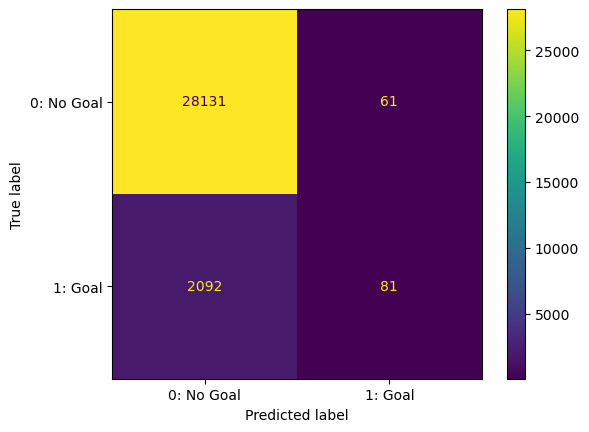

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     28192
           1       0.57      0.04      0.07      2173

    accuracy                           0.93     30365
   macro avg       0.75      0.52      0.52     30365
weighted avg       0.90      0.93      0.90     30365

Test AUC-ROC score: 0.755
Test log loss score: 0.228


In [232]:
# Predict using the pipeline 
y_pred_log_cv = log_best_pipeline.predict(X_test)

# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, y_pred_log_cv)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, y_pred_log_cv)
print(f'Classification report:\n{report}')
# Calculate the AUC-ROC score for the test set
log_best_auc_roc = roc_auc_score(y_test, log_best_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {log_best_auc_roc:.3f}')
log_best_log_loss = log_loss(y_test, log_best_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_best_log_loss:.3f}')

### Visualize CM for best Log Reg Model with SMOTE

In [227]:
# Log Best Params w/ smote
steps = [('preprocess', ct),
        ('smote', SMOTE(sampling_strategy='minority')),
        ('best_model', best_model)]

log_best_pipeline_smote = Pipeline(steps=steps)
log_best_pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromLastEv...
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['shotType', 'game_strength_state'], dtype='object'))])),
                ('smote', SMOTE(sampling_strategy='minority')),
                ('best_model', LogisticRegression(C=0.05, max_iter=10000))])

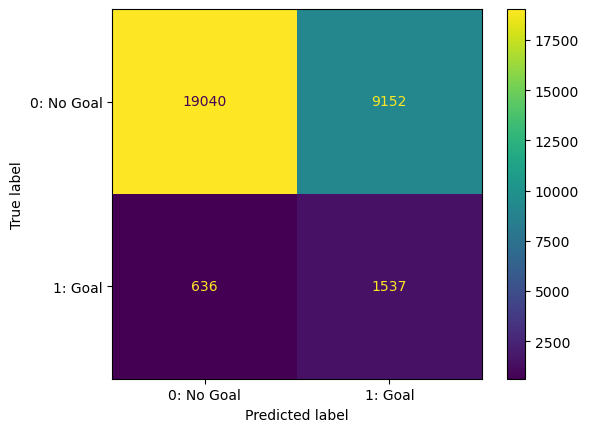

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     28192
           1       0.14      0.71      0.24      2173

    accuracy                           0.68     30365
   macro avg       0.56      0.69      0.52     30365
weighted avg       0.91      0.68      0.76     30365

Test AUC-ROC score: 0.755
Test log loss score: 0.583


In [228]:
# with smote in steps
# Predict using the pipeline 
y_pred_log_cv_smote = log_best_pipeline_smote.predict(X_test)

# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, y_pred_log_cv_smote)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, y_pred_log_cv_smote)
print(f'Classification report:\n{report}')
# Calculate the AUC-ROC score for the test set
log_smote_best_auc_roc = roc_auc_score(y_test, log_best_pipeline_smote.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {log_smote_best_auc_roc:.3f}')
# Calculate the AUC-ROC score for the test set
log_smote_best_log_loss = log_loss(y_test, log_best_pipeline_smote.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_smote_best_log_loss:.3f}')

## XGBoost

In [225]:
# XGBoost CV with smote
steps = [('preprocess', ct),
        ('smote', SMOTE(sampling_strategy='minority')),
#          ('random', RandomOverSampler()),
         ('gradient_booster', XGBClassifier())]

gb_pipeline = Pipeline(steps)

gb_params = {'gradient_booster__n_estimators': [50, 100, 250, 500], 
             'gradient_booster__learning_rate': [.001, .01, .1, 1], 
             'gradient_booster__max_depth': [3, 4, 5, 6]
            }

gb_cv = GridSearchCV(gb_pipeline, param_grid=gb_params, cv=2, verbose=0, error_score='raise',n_jobs=-1)

gb_cv.fit(X_train,y_train)
# print('test: {}'.format(gb_cv.score(X_test,y_test)))
# print('train: {}'.format(gb_cv.score(X_train,y_train)))

11438.29s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11438.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11438.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11438.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11438.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11438.37s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11438.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11438.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11438.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


GridSearchCV(cv=2, error_score='raise',
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEm...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'gradient_booster__learning_rate': [0.001, 0.01, 0.1,
                                                             1],
                         'gradient_booster__max_depth': [3, 4, 5, 6],
                         'gradient_booster__n_estimators': [50, 100, 250, 500]})

In [233]:
# get best parameters
print("Best parameters:", gb_cv.best_params_)

Best parameters: {'gradient_booster__learning_rate': 0.1, 'gradient_booster__max_depth': 5, 'gradient_booster__n_estimators': 500}


In [234]:
# assign to cross validated model params to best_boost
best_boost = gb_cv.best_estimator_.get_params()['gradient_booster']

In [235]:
# XGBoost Best Params
steps = [('preprocess', ct),
         ('smote', SMOTE(sampling_strategy='minority')),
         ('best_boost', best_boost)]

gb_best_pipeline = Pipeline(steps=steps)
gb_best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromLastEv...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=500, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, ...))])

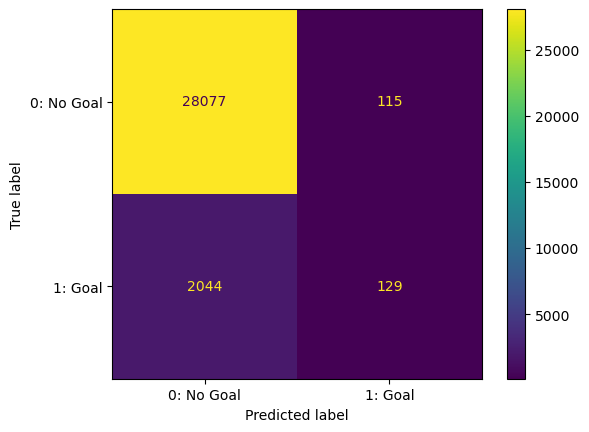

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     28192
           1       0.53      0.06      0.11      2173

    accuracy                           0.93     30365
   macro avg       0.73      0.53      0.53     30365
weighted avg       0.90      0.93      0.90     30365

Test AUC-ROC score: 0.739
Test log loss score: 0.237


In [236]:
# Predict using the pipeline 
y_pred_gb = gb_best_pipeline.predict(X_test)

# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, y_pred_gb)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, y_pred_gb)
print(f'Classification report:\n{report}')
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, gb_best_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, gb_best_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')# Calculate the AUC-ROC score for the test set

## Create subset

In [237]:
# check goal values
shots_df['goal'].value_counts() # binary with 1 representing a goal scored

0    112766
1      8692
Name: goal, dtype: int64

In [241]:
# Take subset of majority class
goals_df = shots_df.loc[shots_df['goal'] == 1]

no_goals = shots_df.loc[shots_df['goal'] == 0].sample(shots_df['goal'].value_counts()[1])
df_sample = pd.concat([no_goals.reset_index(), goals_df.reset_index()],0)
df_sample.shape

(17384, 19)

In [242]:
df_sample= df_sample.drop('index',1)
df_sample.head()

,isHomeTeam,shotType,shotRush,arenaAdjustedShotDistance,arenaAdjustedXCordABS,arenaAdjustedYCordAbs,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotOnEmptyNet,timeSinceLastEvent,distanceFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,speedFromLastEvent,offWing,goal,game_strength_state
0,0.0,WRIST,0,62.000000,29.0,14.0,13.134022,5.300927,0.170998,0,31,55.317267,83,-2,1.784428,0,0,EV5
1,1.0,WRIST,0,8.246211,81.0,2.0,14.036243,1.041627,0.520813,0,2,5.099020,76,3,2.549510,0,0,EV5
2,1.0,WRIST,0,12.165525,77.0,2.0,9.462322,44.628758,22.314379,0,2,45.967380,45,-31,22.983690,0,0,EV5
3,1.0,BACK,0,6.324555,83.0,2.0,18.434949,49.398705,24.699353,0,2,5.099020,84,-3,2.549510,0,0,PP_5v4
4,1.0,WRIST,0,86.000000,11.0,36.0,24.863697,0.000000,0.000000,0,10,90.022219,-83,-36,9.002222,0,0,EV5


In [243]:
X_samp = df_sample.drop('goal',1)
y_samp = df_sample['goal']

In [244]:
X_train_sample,X_test_sample, y_train_sample, y_test_sample = train_test_split(X_samp,y_samp, random_state = 42)

### RandomForestClassifier on dataset sample

In [245]:
# RandomForestClassifier
steps = [('preprocess', ct),
         ('rf_clf', RandomForestClassifier())]

rf_clf_samp = Pipeline(steps)

rf_clf_samp.fit(X_train_sample,y_train_sample)
print('test: {}'.format(rf_clf_samp.score(X_test_sample,y_test_sample)))
print('train: {}'.format(rf_clf_samp.score(X_train_sample,y_train_sample)))

test: 0.670041417395306
train: 1.0


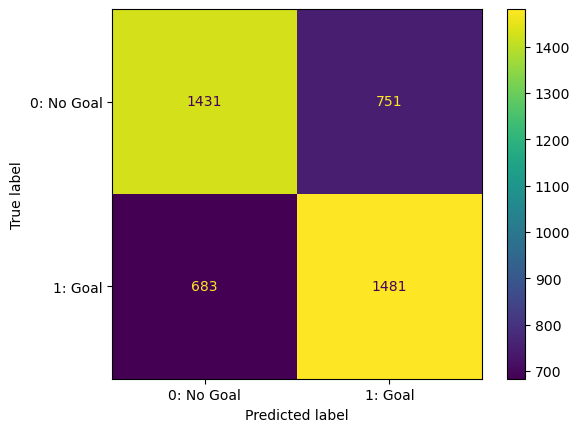

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      2182
           1       0.66      0.68      0.67      2164

    accuracy                           0.67      4346
   macro avg       0.67      0.67      0.67      4346
weighted avg       0.67      0.67      0.67      4346

Test AUC-ROC score: 0.737
Test log loss score: 0.601


In [246]:
# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test_sample, rf_clf_samp.predict(X_test_sample))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test_sample, rf_clf_samp.predict(X_test_sample))
print(f'Classification report:\n{report}')
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test_sample, rf_clf_samp.predict_proba(X_test_sample)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test_sample, rf_clf_samp.predict_proba(X_test_sample)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')# Calculate the AUC-ROC score for the test set

### Logistic Regression CV on Data subset

In [247]:
# Log CV
steps = [('preprocess', ct),
         ('logisticregression', LogisticRegression(max_iter = 10000))]

sampled_log_cv_pipeline = Pipeline(steps=steps)

#paramters to test with the grid search
log_params = {'logisticregression__solver' : ['saga','lbfgs'],
                'logisticregression__penalty': [None,'l2'],
                'logisticregression__C': [.05, 0.1,1]}

sampled_log_cv = GridSearchCV(sampled_log_cv_pipeline, param_grid=log_params, cv=5, verbose=0, error_score='raise')

In [248]:
sampled_log_cv.fit(X_train_sample, y_train_sample)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEm...
                                                                         Pipeline(steps=[('onehotenc',
                                                                                          OneHotEncoder(handle_unknown='ignore')),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         Index(['shotType', 'game_strength_state'], dtype='object'))])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logisticregression__C': [0.05, 0.1, 1],
                         'logisticregression__penalty': [None, 'l2'],
                         'logisticregression__solver': ['saga', 'lbfgs']})

In [249]:
# print best params
sampled_log_cv.best_params_

{'logisticregression__C': 1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'saga'}

In [251]:
# assign params to best_model
sampled_best_model = sampled_log_cv.best_estimator_.get_params()['logisticregression']

In [252]:
# Log Best Params w/o smote
steps = [('preprocess', ct),
        ('sampled_best_model', sampled_best_model)]

sampled_best_pipeline = Pipeline(steps=steps)
sampled_best_pipeline.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromLastEv...
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['shotType', 'game_strength_state'], dtype='object'))])),
                ('sampled_best_model',
                 LogisticRegression(C=1, max_iter=10000, solver='saga'))])

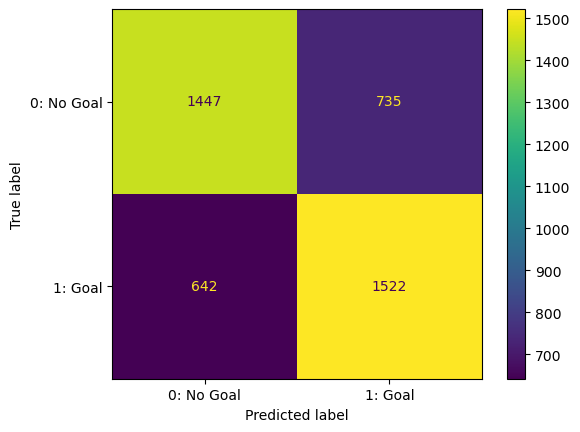

In [253]:
# Predict using the pipeline 
y_pred_log_cv_sampled = sampled_best_pipeline.predict(X_test_sample)

# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test_sample, y_pred_log_cv_sampled)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

In [254]:
# Calculate and print the classification report
report = classification_report(y_test_sample, sampled_best_pipeline.predict(X_test_sample))
print(f'Classification report:\n{report}')
log_best_sampled_auc_roc = roc_auc_score(y_test, sampled_best_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {log_best_sampled_auc_roc:.3f}')
log_best_sampled_log_loss = log_loss(y_test_sample, sampled_best_pipeline.predict_proba(X_test_sample)[:, 1])
print(f'Test log loss score: {log_best_sampled_log_loss:.3f}')

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.68      2182
           1       0.67      0.70      0.69      2164

    accuracy                           0.68      4346
   macro avg       0.68      0.68      0.68      4346
weighted avg       0.68      0.68      0.68      4346

Test AUC-ROC score: 0.756
Test log loss score: 0.586
